# Graph Algorithms in Practice

With Neo4j: Walk through Yelp data analysis that includes a general overview of the data, combining algorithms to make trip recommendations, and mining user and business data for consulting. 

With Spark: we’ll look into US airline data to understand traffic patterns and delays as well as how airports are connected by different airlines.

## Analyzing Yelp Data with Neo4j
Yelp helps people find local businesses based on reviews, preferences, and recommendations. The Yelp dataset represents real data that is very well structured and highly interconnected. 
### Yelp Social network
As well as writing and reading reviews about businesses, users of Yelp form a social network. Users can send friend requests to other users they’ve come across while browsing Yelp.com, or they can connect their address books or Facebook graphs.

Explore the Yelp data
Help people plan trips
Find good recommendations for places to stay and things to do

Help hotels identify influential visitors and business to target for cross-promotion

### Data Import

In [1]:
from neo4j import GraphDatabase
import pandas as pd
#from pandas import iteritems
from tabulate import tabulate
import matplotlib as plt
%matplotlib inline

In [2]:
driver=GraphDatabase.driver("bolt://192.168.42.131", auth=("neo4j", "password"))

# Analyzing Airline Flight Data with Apache Spark

In this section, we’ll use a different scenario to illustrate the analysis of US airport data with Spark. Imagine you’re a data scientist with a considerable travel schedule and would like to dig into information about airline flights and delays. We’ll first explore airport and flight information and then look deeper into delays at two specific airports. Community detection will be used to analyze routes and find the best use of our frequent flyer points.

The US Bureau of Transportation Statistics makes available a significant amount of transportation information. For our analysis, we’ll use their May 2018 air travel ontime performance data, which includes flights originating and ending in the United States in that month. To add more detail about airports, such as location information, we’ll also load data from a separate source, OpenFlights.

In [2]:
from code.script.airline import *

In [3]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName('airline').getOrCreate() 

In [4]:
%matplotlib notebook

In [5]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [11]:
nodes = spark.read.csv(op.join(data_path, "airports.csv"), header=False)

cleaned_nodes = (nodes.select("_c1", "_c3", "_c4", "_c6", "_c7")
                 .filter("_c3 = 'United States'")
                 .withColumnRenamed("_c1", "name")
                 .withColumnRenamed("_c4", "id")
                 .withColumnRenamed("_c6", "latitude")
                 .withColumnRenamed("_c7", "longitude")
                 .drop("_c3"))
cleaned_nodes = cleaned_nodes[cleaned_nodes["id"] != "\\N"]



In [15]:
relationships = spark.read.csv(op.join(data_path, "188591317_T_ONTIME.csv"), header=True)

In [16]:
cleaned_relationships = (relationships
                         .select("ORIGIN", "DEST", "FL_DATE", "DEP_DELAY", "ARR_DELAY",
                                 "DISTANCE", "TAIL_NUM", "FL_NUM", "CRS_DEP_TIME",
                                 "CRS_ARR_TIME", "UNIQUE_CARRIER")
                         .withColumnRenamed("ORIGIN", "src")
                         .withColumnRenamed("DEST", "dst")
                         .withColumnRenamed("DEP_DELAY", "deptDelay")
                         .withColumnRenamed("ARR_DELAY", "arrDelay")
                         .withColumnRenamed("TAIL_NUM", "tailNumber")
                         .withColumnRenamed("FL_NUM", "flightNumber")
                         .withColumnRenamed("FL_DATE", "date")
                         .withColumnRenamed("CRS_DEP_TIME", "time")
                         .withColumnRenamed("CRS_ARR_TIME", "arrivalTime")
                         .withColumnRenamed("DISTANCE", "distance")
                         .withColumnRenamed("UNIQUE_CARRIER", "airline")
                         .withColumn("deptDelay", F.col("deptDelay").cast(FloatType()))
                         .withColumn("arrDelay", F.col("arrDelay").cast(FloatType()))
                         .withColumn("time", F.col("time").cast(IntegerType()))
                         .withColumn("arrivalTime", F.col("arrivalTime").cast(IntegerType()))
                         )



In [17]:
g = GraphFrame(cleaned_nodes, cleaned_relationships)

In [22]:
# Map airline codes to airline names
airlines_reference = (spark.read.csv(op.join(data_path, "airlines.csv"))
      .select("_c1", "_c3")
      .withColumnRenamed("_c1", "name")
      .withColumnRenamed("_c3", "code"))

airlines_reference = airlines_reference[airlines_reference["code"] != "null"]

## Exploratory Analysis

In [23]:
# Count of Airports
g.vertices.count()

1333

In [24]:
# Count of Connections between Airports
g.edges.count()

616529

# Popular Airports

In [29]:
# Degree centrality
airports_degree = g.outDegrees.withColumnRenamed("id", "oId")

full_airports_degree = (airports_degree
                        .join(g.vertices, airports_degree.oId == g.vertices.id)
                        .sort("outDegree", ascending=False)
                        .select("id", "name", "outDegree"))

full_airports_degree.show(n=10, truncate=False)


+---+------------------------------------------------+---------+
|id |name                                            |outDegree|
+---+------------------------------------------------+---------+
|ATL|Hartsfield Jackson Atlanta International Airport|33837    |
|ORD|Chicago O'Hare International Airport            |28338    |
|DFW|Dallas Fort Worth International Airport         |23765    |
|CLT|Charlotte Douglas International Airport         |20251    |
|DEN|Denver International Airport                    |19836    |
|LAX|Los Angeles International Airport               |19059    |
|PHX|Phoenix Sky Harbor International Airport        |15103    |
|SFO|San Francisco International Airport             |14934    |
|LGA|La Guardia Airport                              |14709    |
|IAH|George Bush Intercontinental Houston Airport    |14407    |
+---+------------------------------------------------+---------+
only showing top 10 rows



<IPython.core.display.Javascript object>


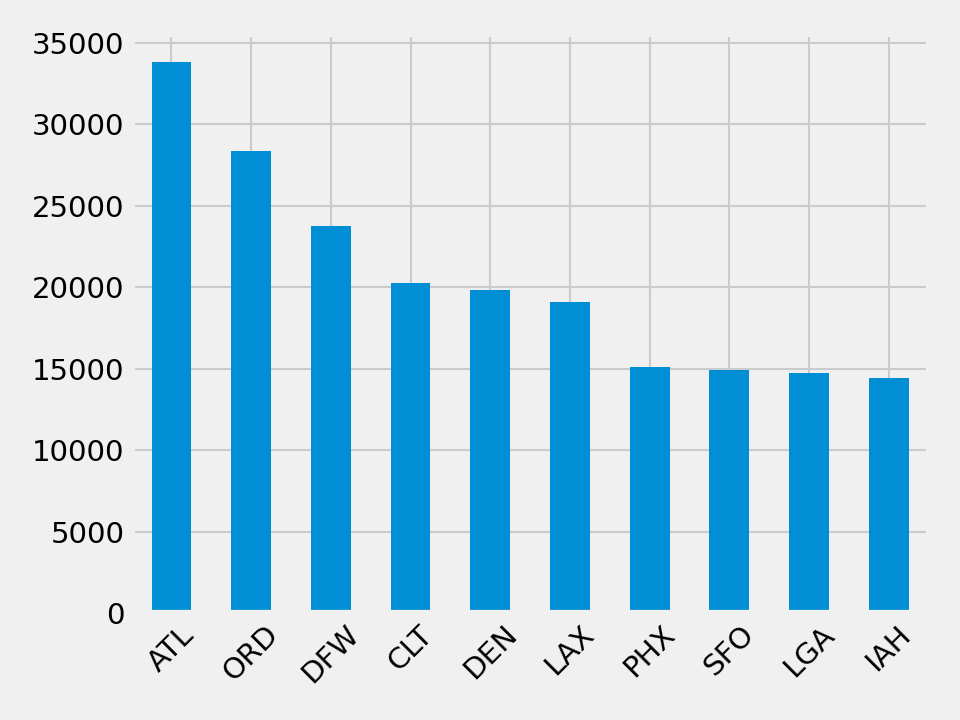

In [30]:
plt.style.use('fivethirtyeight')

ax = (full_airports_degree
      .toPandas()
      .head(10)
      .plot(kind='bar', x='id', y='outDegree', legend=None))

ax.xaxis.set_label_text("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Delays from ORD


In [31]:

delayed_flights = (g.edges
                   .filter("src = 'ORD' and deptDelay > 0")
                   .groupBy("dst")
                   .agg(F.avg("deptDelay"), F.count("deptDelay"))
                   .withColumn("averageDelay", F.round(F.col("avg(deptDelay)"), 2))
                   .withColumn("numberOfDelays", F.col("count(deptDelay)")))

(delayed_flights
 .join(g.vertices, delayed_flights.dst == g.vertices.id)
 .sort(F.desc("averageDelay"))
 .select("dst", "name", "averageDelay", "numberOfDelays")
 .show(n=10, truncate=False))

+---+-------------------------------------------+------------+--------------+
|dst|name                                       |averageDelay|numberOfDelays|
+---+-------------------------------------------+------------+--------------+
|CKB|North Central West Virginia Airport        |145.08      |12            |
|OGG|Kahului Airport                            |119.67      |9             |
|MQT|Sawyer International Airport               |114.75      |12            |
|MOB|Mobile Regional Airport                    |102.2       |10            |
|TTN|Trenton Mercer Airport                     |101.18      |17            |
|AVL|Asheville Regional Airport                 |98.5        |28            |
|ISP|Long Island Mac Arthur Airport             |94.08       |13            |
|ANC|Ted Stevens Anchorage International Airport|83.74       |23            |
|BTV|Burlington International Airport           |83.2        |25            |
|CMX|Houghton County Memorial Airport           |79.18       |17

"This is interesting, but one data point really stands out: 12 flights from ORD to CKB
have been delayed by more than 2 hours on average! Let’s find the flights between
those airports and see what’s going on:"

In [32]:
from_expr = 'id = "ORD"'
to_expr = 'id = "CKB"'
ord_to_ckb = g.bfs(from_expr, to_expr)

ord_to_ckb = ord_to_ckb.select(
  F.col("e0.date"),
  F.col("e0.time"),
  F.col("e0.flightNumber"),
  F.col("e0.deptDelay"))


<IPython.core.display.Javascript object>


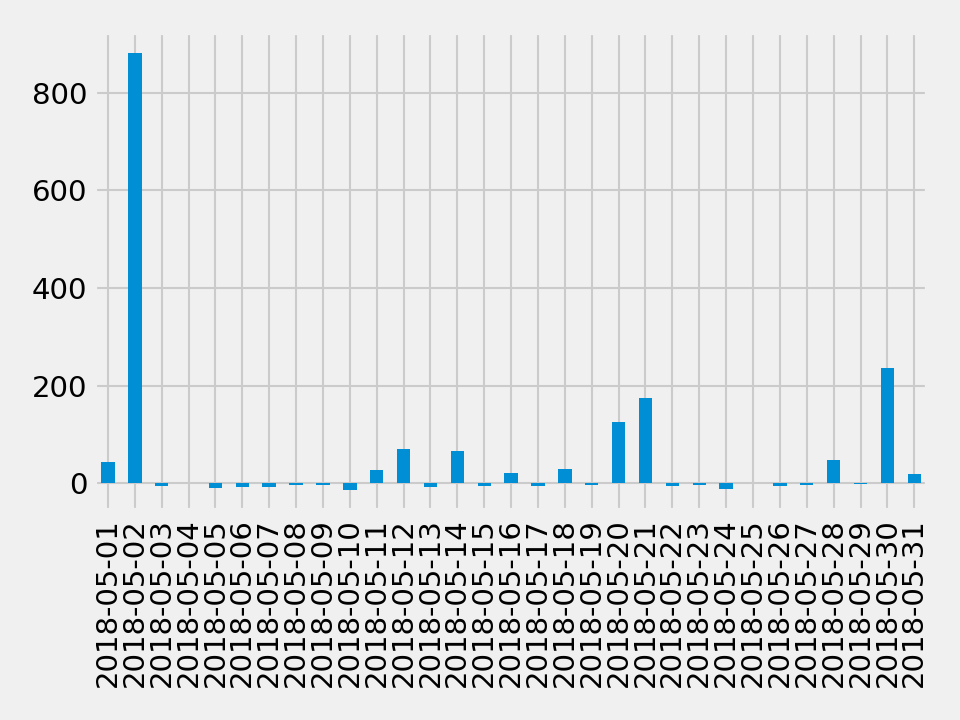

In [33]:
ax = (ord_to_ckb
      .sort("date")
      .toPandas()
      .plot(kind='bar', x='date', y='deptDelay', legend=None))

ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()


## Bad Day at SFO
Let’s consider delays at an airport known for fog-related “low ceiling” issues: San Francisco International Airport (SFO). One method for analysis would be to look at motifs, which are recurrent subgraphs or patterns.

In [34]:
motifs = (g.find("(a)-[ab]->(b); (b)-[bc]->(c)")
          .filter("""(b.id = 'SFO') and
                  (ab.date = '2018-05-11' and bc.date = '2018-05-11') and
                  (ab.arrDelay > 30 or bc.deptDelay > 30) and
                  (ab.flightNumber = bc.flightNumber) and
                  (ab.airline = bc.airline) and
                  (ab.time < bc.time)"""))


The motif (a)-[ab]->(b); (b)-[bc]->(c) finds flights coming into and out from
the same airport. We then filter the resulting pattern to find flights with:
- A sequence where the first flight arrives at SFO and the second flight departs
from SFO
- Delays of over 30 minutes when arriving at or departing from SFO
- The same flight number and airline

In [ ]:
result = (motifs.withColumn("delta", motifs.bc.deptDelay - motifs.ab.arrDelay)
          .select("ab", "bc", "delta")
          .sort("delta", ascending=False))

result.select(
    F.col("ab.src").alias("a1"),
    F.col("ab.time").alias("a1DeptTime"),
    F.col("ab.arrDelay"),
    F.col("ab.dst").alias("a2"),
    F.col("bc.time").alias("a2DeptTime"),
    F.col("bc.deptDelay"),
    F.col("bc.dst").alias("a3"),
    F.col("ab.airline"),
    F.col("ab.flightNumber"),
    F.col("delta")
).show()